<a href="https://colab.research.google.com/github/TheClassicTechno/cleansea_model/blob/main/Keras_CNN_Model_Baseline_for_Cleansea_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Keras CNN Model Baseline for Cleansea



In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pathlib
import cv2
import glob
import json
%matplotlib inline
import seaborn as sns; sns.set()
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import os

##Mounting the drive so it can access the taco dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Reading the JSON file which has all the annotations, image urls and other information such as categories, supercategories etc.

In [3]:
dataset_path = '/content/drive/MyDrive/TEAM9SURESTART/TACO-master/data/'

anns_file_path = dataset_path + '/' + 'annotations.json'
# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
super_cat = dataset['scene_categories']
anns = dataset['annotations']
imgs = dataset['images']
print(imgs[20]['file_name'])
print(categories[20])



batch_1/000040.jpg
{'supercategory': 'Cup', 'id': 20, 'name': 'Paper cup'}


In [4]:
!python3 '/content/drive/MyDrive/TEAM9SURESTART/TACO-master/download.py'

Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Traceback (most recent call last):
  File "/content/drive/MyDrive/TEAM9SURESTART/TACO-master/download.py", line 23, in <module>
    with open(args.dataset_path, 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TEAM 9 SURESTART CREATEATHON/TACO-master/data/annotations.json'


Downloading Images from Flickr (Don't RUN THIS LINE AGAIN, the pics have already been downloaded)

#Trying to display an image from the dataset

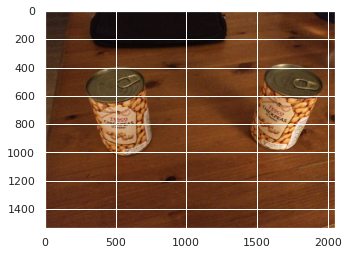

In [5]:
#Trying to show my own image
img = mpimg.imread(os.path.join(dataset_path , imgs[20]['file_name']))


# img variable contains the pixels

plt.imshow(img)
plt.show()

##Checking how many of each type exist in the json file

Going to use 12 for training and validation and 3 for testing 

10 in training
2 in validation

In [6]:
counter = 0

for batch in range(1, 15): 
  b = os.listdir(dataset_path + 'batch_' + str(batch))
  batch = len(b)
  counter += batch

print(counter)
# 1547 pictures 

1547


##Splitting the Data 

In [7]:
!python3 '/content/drive/MyDrive/TEAM9SURESTART/TACO-master/detector/split_dataset.py'  --dataset_dir '/content/drive/MyDrive/TEAM9SURESTART/TACO-master/data/'


## training data

In [8]:
from collections import Counter

anns_file_path = dataset_path + '/' + 'annotations_0_train.json'
# Read annotations
with open(anns_file_path, 'r') as f:
    train_dataset = json.loads(f.read())

train_images = []
train_images_ID = []
train_labels = []
imgs = train_dataset['images']
annotations = train_dataset['annotations']


for index in range(len(imgs)):
  train_images_ID.append(imgs[index]['id'])
  train_images.append('/content/drive/MyDrive/TEAM9SURESTART/TACO-master/data/' + imgs[index]['file_name'])
  mini_dict = list(filter(lambda ID: ID['id'] == train_images_ID[index], annotations))
  if(len(mini_dict) > 0):
    train_labels.append(mini_dict[0]['category_id'])
  else:
    train_labels.append(61)

for i, category in enumerate(train_labels):
  if(category == 61):
    train_images[i] = 61
    train_images_ID[i] = 61
  
train_images = list(filter((61).__ne__, train_images))
train_images_ID = list(filter((61).__ne__, train_images_ID))
train_labels = list(filter((61).__ne__, train_labels))


##Validation data

In [10]:
from collections import Counter

anns_file_path = dataset_path + '/' + 'annotations_0_val.json'
# Read annotations
with open(anns_file_path, 'r') as f:
    val_dataset = json.loads(f.read())

val_images = []
val_images_ID = []
val_labels = []
val = val_dataset['images']
annotations = val_dataset['annotations']


for index in range(len(imgs)):
  val_images_ID.append(imgs[index]['id'])
  val_images.append('/content/drive/MyDrive/TEAM9SURESTART/TACO-master/data/' + imgs[index]['file_name'])
  mini_dict = list(filter(lambda ID: ID['id'] == val_images_ID[index], annotations))
  if(len(mini_dict) > 0):
    val_labels.append(mini_dict[0]['category_id'])
  else:
    val_labels.append(61)

for i, category in enumerate(val_labels):
  if(category == 61):
    val_images[i] = 61
    val_images_ID[i] = 61
  
val_images = list(filter((61).__ne__, val_images))
val_images_ID = list(filter((61).__ne__, val_images_ID))
val_labels = list(filter((61).__ne__, val_labels))



##cnn model architecture

In [20]:

model = Sequential ([
    layers.Rescaling(1./255, input_shape = (128, 128, 3)),
    #layers.RandomFlip("horizontal_and_vertical"),
    #layers.RandomRotation(0.2),
    layers.Conv2D(256, 3, padding = 'same', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
     layers.Conv2D(256, 3, padding = 'same', activation = 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(15, activation = 'softmax')
])

'''
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape = (512, 512, 3)))
model.add(layers.Conv2D(16, (5, 5), activation='relu',padding = 'same'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.MaxPool2D(pool_size=(3, 3)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same'))
model.add(layers.MaxPool2D(pool_size=(3, 3)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(16, (3, 3), activation='relu',padding = 'same'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(15, activation = 'softmax'))
model.summary()
'''
'''
model = Sequential ([
    layers.Rescaling(1./255, input_shape = (512, 512, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(15)
])
'''
model.summary()
'''
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.name = 'L2 Regularization model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)
'''

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 64, 64, 256)      0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 64, 64, 256)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                 

"\nreg_model = models.Sequential()\nreg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))\nreg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))\nreg_model.add(layers.Dense(3, activation='softmax'))\nreg_model.name = 'L2 Regularization model'\nreg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)\nreg_min = optimal_epoch(reg_history)\n"

##split into train and validation and fit the model

In [21]:
train_images = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/TEAM9SURESTART/TACO-master/data/',
    validation_split = 0.1,
    subset = "training",
    seed = 24,  
    image_size = (128, 128),
    batch_size = 64
)

val_images = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/TEAM9SURESTART/TACO-master/data/',
    validation_split = 0.1,
    subset = "validation",
    seed = 24,  
    image_size = (128, 128),
    batch_size = 64
)
train_images = train_images.cache().shuffle(13).prefetch(buffer_size = tf.data.AUTOTUNE)
val_images = val_images.cache().shuffle(13).prefetch(buffer_size = tf.data.AUTOTUNE)
STEPS=(1504/64)*120
initial_learning_rate=1e-3 #was 1e-3 then 1e-4 before
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, STEPS)


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_decayed_fn),
    metrics=['accuracy'],  run_eagerly=True
)
#model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit (
    train_images, 
    validation_data = val_images,
    epochs = 120
)


Found 1671 files belonging to 15 classes.
Using 1504 files for training.
Found 1671 files belonging to 15 classes.
Using 167 files for validation.
Epoch 1/120
24/24 [==============================] - 19s 228ms/step - loss: 2.7223 - accuracy: 0.0698 - val_loss: 2.6969 - val_accuracy: 0.0778
Epoch 2/120
24/24 [==============================] - 2s 103ms/step - loss: 2.7006 - accuracy: 0.0831 - val_loss: 2.7037 - val_accuracy: 0.0838
Epoch 3/120
24/24 [==============================] - 2s 100ms/step - loss: 2.7006 - accuracy: 0.0751 - val_loss: 2.6964 - val_accuracy: 0.1257
Epoch 4/120
24/24 [==============================] - 2s 97ms/step - loss: 2.6954 - accuracy: 0.0791 - val_loss: 2.6777 - val_accuracy: 0.0838
Epoch 5/120
24/24 [==============================] - 2s 97ms/step - loss: 2.6686 - accuracy: 0.1031 - val_loss: 2.6659 - val_accuracy: 0.1257
Epoch 6/120
24/24 [==============================] - 2s 95ms/step - loss: 2.6219 - accuracy: 0.1197 - val_loss: 2.6290 - val_accuracy: 0.06

##visualize results

Text(0.5, 1.0, 'Training-Validation Accuracy')

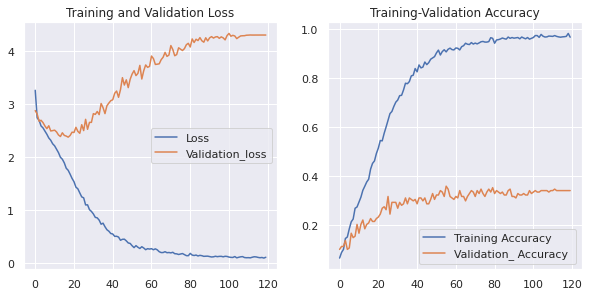

In [13]:
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

##save model

In [14]:
model.save('model.h5') 

#later, this saved model.h5 can be easily integrated into a mobile app for users